In [14]:
import pandas as pd
df = pd.read_csv("../input/dnazymes/All_Seqeunces.tsv",sep='\t')
df['Label_Binary'] = df['Label_Binary'].apply(lambda x: 1 if x == 'DNAzyme' else 0) 
df['GC_Content'] = df.Sequence.apply(lambda seq: (seq.count('G')+seq.count('C'))/len(seq))
df['Length'] = df.Sequence.apply(lambda x: len(x))
df = df[df.Length < 1e3]
df['Length_Norm'] = (df.Length - df.Length.min())/(df.Length.max() - df.Length.min())
df.reset_index()
print(df.shape)

(26654, 10)


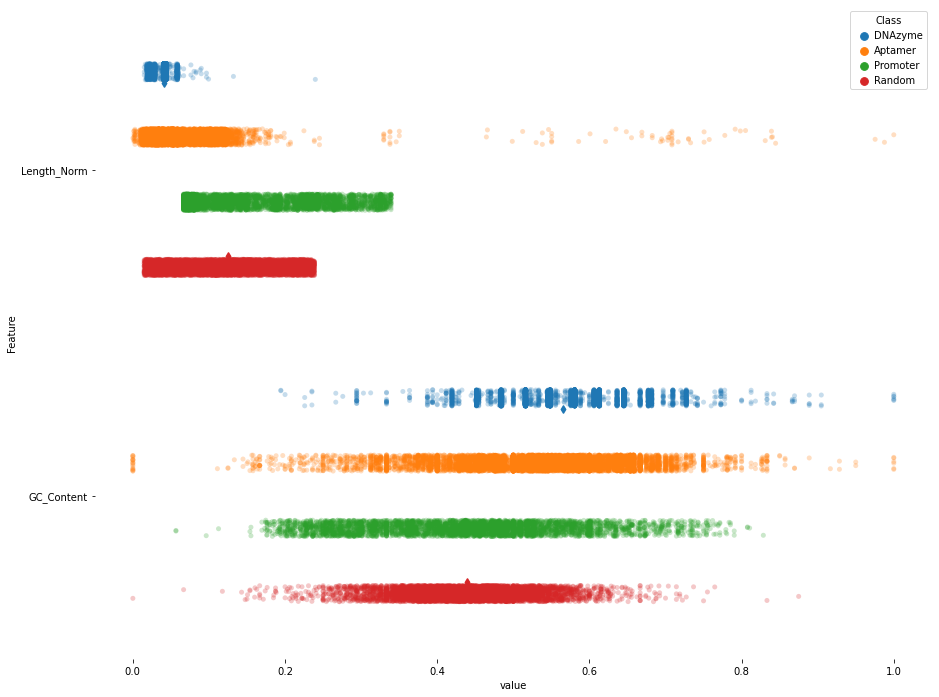

In [15]:
plot_df = pd.melt(df[['Label','Length_Norm','GC_Content']],'Label',var_name='Feature')

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(15,12))
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(x="value", y="Feature", hue="Label",
              data=plot_df, dodge=True, alpha=.25, zorder=1)

# Show the conditional means
sns.pointplot(x="value", y="Feature", hue="Label",
              data=plot_df, dodge=.532, join=False,
              markers="d", scale=.75, ci=None)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:4], labels[:4], title="Class",
          handletextpad=0, columnspacing=1)


In [23]:
from sklearn.model_selection import train_test_split

def split_data(df):
    TRAIN_RATIO = 0.75
    TEST_RATIO = 0.15
    VALIDATION_RATIO = 0.10
    test_size = 1-TRAIN_RATIO
    validation_size = TEST_RATIO/(TEST_RATIO + VALIDATION_RATIO)
    index = list(range(df.shape[0]))
    # Splitting data and returning  only the indices
    _, X_test, _, y_test, train_indices, test_indices = train_test_split(df['Sequence'], df['Label'], index, test_size=test_size)
    _, _, _, _, validation_indices, test_indices = train_test_split(X_test, y_test, test_indices, test_size=validation_size)
    return train_indices, test_indices, validation_indices

In [24]:
train_indices, test_indices, validation_indices = split_data(df) # split data into train, validation and test
import random
random.shuffle(train_indices) #shuffling required for partial_fit of SGDClassifier (inplace)
random.shuffle(test_indices)
random.shuffle(validation_indices)
print(len(train_indices),len(test_indices),len(validation_indices),df.shape)

19990 3999 2665 (26654, 10)


In [25]:
import numpy as np
from sklearn.feature_extraction.text import HashingVectorizer
kmer_len = 6 #size of kmers 
n_features = 4**kmer_len+1 #number of unique possible kmers to avoid collisions in hashing
VECTORIZER = HashingVectorizer(n_features=n_features) #encodes strings as kmer hashes

# turn a string into a list of non-overlapping kmers (1 space delimited string)
def get_kmers(seq, size=kmer_len):
    return ' '.join([seq[x:x+size].upper() for x in range(len(seq) - size + 1)])

def seqs_to_vector(seq_list):
    kmers = [get_kmers(seq) for seq in seq_list] #list of kmers of size kmer_len per seq
    return VECTORIZER.transform(kmers).toarray() #vectorize 
    
def get_chunk(df,start,end):
    if start > df.shape[0]: # nothing left
        return np.asarray([], dtype=int), np.asarray([], dtype=int)
    if end > df.shape[0]: #end idx past data left
        end = df.shape[0]
    seqs = df.iloc[start:end,df.columns.get_loc('Sequence')].values #chunk_size seqs
    X = seqs_to_vector(seqs)
    y = df.iloc[start:end,df.columns.get_loc('Label_Binary')].values
    return X,y
        

# generator for data for out-of-core training
# yields chunks of 5000 data points of vectorized DNA seq and labels at a time
# DNA seq is a frequency array of all possible kmers of size kmer_len
def make_data_generator(df):
    chunk_size = 5000
    def _my_generator():
        i = 0
        X,y = get_chunk(df,i,chunk_size)
        while len(X): #while rows left to yeild
            yield X,y 
            i += chunk_size
            X,y = get_chunk(df,i,i+chunk_size)
    return _my_generator()
            

In [27]:
print(max(train_indices),max(test_indices),max(validation_indices),df.shape)

26651 26653 26652 (26654, 10)


In [28]:
training_generator = make_data_generator(df.iloc[train_indices,:]) #generator for training data

#from sklearn.naive_bayes import MultinomialNB
#model = MultinomialNB(alpha=0.01)

from sklearn.linear_model import SGDClassifier
#like a linear kernel SVM but allows for partial_fit() and predict_proba() methods
model = SGDClassifier(loss="modified_huber", penalty="l2", max_iter=5) 
for i,(X,y) in enumerate(training_generator):
    model.partial_fit(X,y, classes=np.asarray([0,1]))
    print(i)

0
1
2
3


In [31]:
import sklearn.metrics as metrics
X_seqs = df.iloc[validation_indices,4].values
X_test, y_test = seqs_to_vector(X_seqs), df.iloc[validation_indices,6].values
y_pred = model.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='weighted')
recall = metrics.recall_score(y_test, y_pred, average='weighted')
confusion_matrix = pd.crosstab(pd.Series(y_test, name='Actual'),
                               pd.Series(y_pred, name='Predicted'))
print(accuracy,precision,recall)
print(confusion_matrix)

0.9924953095684803 0.9925285010448603 0.9924953095684803
Predicted     0    1
Actual              
0          2032    2
1            18  613


In [34]:
# save trained model to a file to make predictions#g #g #g 
import pickle
model_file = 'dnazyme_SGD_Classifier.pickle'
pickle.dump(model, open(model_file, 'wb'))